First, manually look through the images to see if there are any obvious defects with the images.

Characters missing due to font issue, only affects numbers. They are replaced by a logo thing. 
- 1bjj6-0.png 
- 5b2bh05-0.png
- 77sbo-0.png
- kaq2m3-0.png 
- vtw6ql-0.png
- r48sp-0.png


Others
- g8elpi-0.png (8 is missing in the font, it is represented by a rectangle symbol instead)
- 8ouita-0.png (missing number in font, replaced by rectangle symbol)
- 0ilhrs2t-0.png (the characters get cut off)

On first look through, the observations are
- number of charcters in the captcha varies
- each of the character will have color but none of them seem to be black 
- lines going through character varies, could be removed if just remove all the black elements from the image
- size of images varies, will have to resize

In [46]:
import cv2
import numpy as np
import os


In [47]:
# To remove the lines going across the characters

def remove_isolated_black_pixels(image):
    # Convert the image to grayscale if it's not already
    if len(image.shape) == 3:
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        gray = image.copy()

    # Create a mask for black pixels
    black_pixels = (gray == 0)

    # Create a mask for non-black pixels
    non_black_pixels = (gray > 0)

    # Dilate the non-black pixels to include neighboring pixels
    kernel = np.ones((1, 1), np.uint8)  # 3x3 kernel for 8-neighborhood
    dilated_non_black = cv2.dilate(non_black_pixels.astype(np.uint8), kernel, iterations=1)

    # Keep black pixels only if they are adjacent to non-black pixels or if theyre the colored pixels
    preserved = black_pixels & (dilated_non_black > 0) | non_black_pixels

    # Create the output image
    result = image.copy()
    if len(image.shape) == 3:  # Color image
        result[~preserved] = [255, 255, 255]  # Set non-preserved black pixels to white
    else:  # Grayscale image
        result[~preserved] = 255  # Set non-preserved black pixels to white

    return result

# Load the image
image = cv2.imread('main/k070g5pe-0.png')
# image = cv2.imread('main/g0hp-0.png')

# Remove isolated black pixels
result = remove_isolated_black_pixels(image)

# Save or display the 

cv2.imwrite('output_image.png', result)
# cv2.imshow('Result', result)
# cv2.waitKey(0)
# cv2.destroyAllWindows()

True

In [49]:
def preprocess_image(image):
    # Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Remove the white background
    _, filtered = cv2.threshold(gray, 254, 255, cv2.THRESH_BINARY_INV)

    return filtered

def find_character_bounding_boxes(filtered):
    # Find connected components
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(filtered, connectivity=8)
    
    bounding_boxes = []
    for i in range(1, num_labels):  # Skip the background (label 0)
        x, y, w, h, area = stats[i]
        bounding_boxes.append((x, y, w, h))

    return bounding_boxes


# Sort bounding boxes from left to right
def sort_bounding_boxes(bounding_boxes):
    return sorted(bounding_boxes, key=lambda box: box[0])

def find_dominant_color(image, mask):
    x, y, w, h = mask
    image = image[y:y+h, x:x+w]

    pixels = image.reshape(-1, 3).astype(np.uint16)

    # Remove white pixels to not interfere with the dominant color
    pixels = pixels[~np.all(pixels >254, axis=1)]

    # Compute the color histogram
    hist = np.bincount(pixels[:, 0] * 256 * 256 + pixels[:, 1] * 256 + pixels[:, 2], minlength=256 * 256 * 256)
    
    # Find the most frequent color
    dominant_color_index = np.argmax(hist)
    dominant_color = (
        (dominant_color_index // (256 * 256)) % 256,  # Red
        (dominant_color_index // 256) % 256,          # Green
        dominant_color_index % 256                    # Blue
    )

    return dominant_color



def merge_bounding_boxes(bounding_boxes, image):

    boxes = [bounding_boxes[0]]

    for i in range (1, len(bounding_boxes)):
        x, y, w, h = bounding_boxes[i]
        prev_x, prev_y, prev_w, prev_h = boxes[-1]

        # If the color of the segments are the same, likely is part of the same character
        if find_dominant_color(image, bounding_boxes[i]) == find_dominant_color(image, boxes[-1]):
            new_x = min(x, prev_x)
            new_y = min(y, prev_y)
            new_w = max(x + w, prev_x + prev_w) - new_x
            new_h = max(y + h, prev_y + prev_h) - new_y
            boxes[-1] = (new_x, new_y, new_w, new_h)
        else:
            boxes.append((x, y, w, h))  
    
    return boxes

# Remove oulier bounding boxes which may be too small to contain any characters
def remove_noise(bounding_boxes):
    threshold = 2

    boxes = bounding_boxes.copy()

    areas = []
    for box in boxes:
        x, y, w, h = box

        # Remove boxes which are too small to contain any characters
        if w < 5 or h < 5:
            bounding_boxes.remove(box)
        else:
            areas.append(w * h)


    # TODO: Complete the outlier part of the filtering process 
    # areas = np.array(areas)
    # mean_area = np.mean(areas)
    # std_area = np.std(areas)

    # outliers = np.where(np.abs(areas - mean_area) > threshold * std_area)[0]

    # print(outliers)
    # print(len(areas))
    # print(areas)
    # bounding_boxes.remove(bounding_boxes[i] for i in outliers)

    return bounding_boxes

def separate_connected_characters(bounding_boxes):
    ratio_threshold = 1.5

    boxes = bounding_boxes.copy()

    for box in boxes:
        x, y, w, h = box

        # TODO: Could be improved to check for color when spliting
        # Check if the width is larger than the height by a certain ratio
        if w > ratio_threshold * h:
            # Separate the characters by cutting in half
            bounding_boxes.remove(box)
            bounding_boxes.append((x, y, w // 2, h))
            bounding_boxes.append((x + w // 2, y, w // 2, h))
    
    return bounding_boxes



def extract_characters(image, bounding_boxes):
    characters = []
    for (x, y, w, h) in bounding_boxes:
        char = image[y:y+h, x:x+w]
        characters.append(char)
    return characters

def save_characters(characters, output_dir="output_characters"):
    os.makedirs(output_dir, exist_ok=True)
    for i, char in enumerate(characters):
        cv2.imwrite(os.path.join(output_dir, f"char_{i}.png"), char)

image = cv2.imread('output_image.png')

# Preprocess the image
filtered = preprocess_image(image)

# Find character bounding boxes
bounding_boxes = find_character_bounding_boxes(filtered)

# Sort bounding boxes from left to right
bounding_boxes = sort_bounding_boxes(bounding_boxes)

# Merge bounding boxes with the same color
bounding_boxes = merge_bounding_boxes(bounding_boxes, image)       

# TODO: Filter boxes which are small, likely noise
bounding_boxes  = remove_noise(bounding_boxes)

# TODO: Separate characters which may be connected together (width larger than height by a certain ratio)
bounding_boxes = separate_connected_characters(bounding_boxes)

# Extract characters
characters = extract_characters(filtered, bounding_boxes)

# Save characters as separate images
save_characters(characters)

# Display the result with bounding boxes
output = image.copy()
for (x, y, w, h) in bounding_boxes:
    cv2.rectangle(output, (x, y), (x + w, y + h), (0, 255, 0), 2)

# cv2.imshow('Result', output)
# cv2.waitKey(0)
# cv2.destroyAllWindows()

Code to itterate through the train data to separate the characters

In [ ]:
failed = []


def process_image(filename, file_path):
    image = cv2.imread(filename)

    clean_image = remove_isolated_black_pixels(image)

    filtered = preprocess_image(clean_image)

    # Find character bounding boxes
    bounding_boxes = find_character_bounding_boxes(filtered)

    # Sort bounding boxes from left to right
    bounding_boxes = sort_bounding_boxes(bounding_boxes)

    # Merge bounding boxes with the same color
    bounding_boxes = merge_bounding_boxes(bounding_boxes, image)       

    # TODO: Filter boxes which are small, likely noise
    bounding_boxes  = remove_noise(bounding_boxes)

    print(len(bounding_boxes))


    # For checking seperated images
    # output = image.copy()
    # for (x, y, w, h) in bounding_boxes:
    #     cv2.rectangle(output, (x, y), (x + w, y + h), (0, 255, 0), 2)
        
    # cv2.imshow('Result', output)
    # cv2.waitKey(0)
    # cv2.destroyAllWindows()

    filename = filename.split('-')[0].split('/')[1]
    characters_num = len(filename)


    if characters_num == len(bounding_boxes):
        characters = extract_characters(filtered, bounding_boxes)
        path = file_path+'_extracted'
        save_characters(characters, filename, path)
        print('success')
    else:
        print('failed')
        failed.append(filename)
        


def save_characters(characters, filename, output_dir="output_characters"):
    name = filename.split('-')[0]
    chars = list(name)

    os.makedirs(output_dir, exist_ok=True)
    for i, char in enumerate(characters):
        cv2.imwrite(os.path.join(output_dir, f"{chars[i]}-{name} [{i}].png"), char)


file_paths = ['train', 'test']

for file_path in file_paths:
    for i, filename in enumerate(os.listdir(file_path)):
        process_image(file_path+'/'+filename, file_path) 
        print(f'Passed: {[i+1-len(failed)]}, failed: {len(failed)}')

    
    print(failed)
    output_dir = 'failed-'+file_path

    os.makedirs(output_dir, exist_ok=True)
    for name in failed:
        filename = name+'-0.png'

        image = cv2.imread('test/'+filename)
        cv2.imwrite(os.path.join(output_dir, filename), image)


8
success
Passed: [1], failed: 0
4
success
Passed: [2], failed: 0
7
success
Passed: [3], failed: 0
3
failed
Passed: [3], failed: 1
5
success
Passed: [4], failed: 1
8
success
Passed: [5], failed: 1
5
success
Passed: [6], failed: 1
5
success
Passed: [7], failed: 1
4
success
Passed: [8], failed: 1
3
failed
Passed: [8], failed: 2
4
success
Passed: [9], failed: 2
8
success
Passed: [10], failed: 2
5
success
Passed: [11], failed: 2
5
success
Passed: [12], failed: 2
5
success
Passed: [13], failed: 2
7
success
Passed: [14], failed: 2
2
failed
Passed: [14], failed: 3
8
success
Passed: [15], failed: 3
5
success
Passed: [16], failed: 3
7
success
Passed: [17], failed: 3
6
success
Passed: [18], failed: 3
5
success
Passed: [19], failed: 3
8
success
Passed: [20], failed: 3
4
success
Passed: [21], failed: 3
8
success
Passed: [22], failed: 3
6
success
Passed: [23], failed: 3
4
success
Passed: [24], failed: 3
8
success
Passed: [25], failed: 3
8
success
Passed: [26], failed: 3
4
success
Passed: [27], fail

Code to load CK's extracted data for model


In [50]:
import os
import cv2
import numpy as np
from sklearn.preprocessing import LabelEncoder

def load_images_from_folder(folder_path, target_size, color_mode):
    images = []
    labels = []
    valid_extensions = ['.jpg', '.jpeg', '.JPG', '.JPEG','.png']
    channels = 1 if color_mode == 'grayscale' else 3

    for filename in os.listdir(folder_path):
        if any(filename.endswith(ext) for ext in valid_extensions):
            file_path = os.path.join(folder_path, filename)
            try:
                # Read image
                if color_mode == 'grayscale':
                    image = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
                else:
                    image = cv2.imread(file_path)
                    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                
                # Resize and normalize
                image = cv2.resize(image, target_size)
                image = image.astype('float32') / 255.0
                
                # Add channel dimension if grayscale
                if channels == 1:
                    image = np.expand_dims(image, axis=-1)
                
                # Store image and label
                images.append(image)
                labels.append(os.path.splitext(filename)[0].split('-')[0])
                
            except Exception as e:
                print(f"Error processing {filename}: {str(e)}")
                continue
                
    return np.array(images), np.array(labels)

def prepare_fixed_split(train_dir, test_dir, target_size=(28, 28), color_mode='grayscale'):

    # Load training data
    X_train, train_labels = load_images_from_folder(train_dir, target_size, color_mode)
    
    # Load test data
    X_test, test_labels = load_images_from_folder(test_dir, target_size, color_mode)
    
    # Combine labels to ensure consistent encoding
    all_labels = np.concatenate([train_labels, test_labels])
    label_encoder = LabelEncoder()
    label_encoder.fit(all_labels)
    
    # Encode both sets of labels
    y_train = label_encoder.transform(train_labels)
    y_test = label_encoder.transform(test_labels)
    
    return X_train, X_test, y_train, y_test, label_encoder

if __name__ == "__main__":
    train_dir = "train_extracted"
    test_dir = "test_extracted"
    target_size = (28, 28) 
    color_mode = 'grayscale' 

    # Load and prepare data
    X_train, X_test, y_train, y_test, label_encoder = prepare_fixed_split(
        train_dir, test_dir, target_size, color_mode
    )

    # Verify shapes and classes
    print(f"Training data shape: {X_train.shape}")
    print(f"Training labels shape: {y_train.shape}")
    print(f"Test data shape: {X_test.shape}")
    print(f"Test labels shape: {y_test.shape}")
    print(f"Number of classes: {len(label_encoder.classes_)}")
    print(f"Class names: {label_encoder.classes_}")

KeyboardInterrupt: 

Code to load Pooja's extracted characters

In [ ]:
# Code to load Pooja's extracted characters

import os
import cv2
import numpy as np
from sklearn.preprocessing import LabelEncoder

def load_images_from_folder(folder_path, target_size, color_mode):
    images = []
    labels = []
    valid_extensions = ['.jpg', '.jpeg', '.JPG', '.JPEG','.png']
    channels = 1 if color_mode == 'grayscale' else 3

    for label in os.listdir(folder_path):
        sub_folder_path = os.path.join(folder_path, label)
        for filename in os.listdir(sub_folder_path):
            if any(filename.endswith(ext) for ext in valid_extensions):
                file_path = os.path.join(sub_folder_path, filename)
                try:
                    # Read image
                    if color_mode == 'grayscale':
                        image = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
                    else:
                        image = cv2.imread(file_path)
                        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                    
                    # Resize and normalize
                    image = cv2.resize(image, target_size)
                    image = image.astype('float32') / 255.0
                    
                    # Add channel dimension if grayscale
                    if channels == 1:
                        image = np.expand_dims(image, axis=-1)
                    
                    # Store image and label
                    images.append(image)
                    labels.append(label)
                    
                except Exception as e:
                    print(f"Error processing {filename}: {str(e)}")
                    continue
                
    return np.array(images), np.array(labels)

def prepare_fixed_split(train_dir, test_dir, target_size=(28, 28), color_mode='grayscale'):

    # Load training data
    X_train, train_labels = load_images_from_folder(train_dir, target_size, color_mode)
    
    # Load test data
    X_test, test_labels = load_images_from_folder(test_dir, target_size, color_mode)
    
    # Combine labels to ensure consistent encoding
    all_labels = np.concatenate([train_labels, test_labels])
    label_encoder = LabelEncoder()
    label_encoder.fit(all_labels)
    
    # Encode both sets of labels
    y_train = label_encoder.transform(train_labels)
    y_test = label_encoder.transform(test_labels)
    
    return X_train, X_test, y_train, y_test, label_encoder

if __name__ == "__main__":
    train_dir = "output-train-by-char"
    test_dir = "output-test"
    target_size = (28, 28) 
    color_mode = 'grayscale' 

    # Load and prepare data
    X_train, X_test, Y_train, Y_test, label_encoder = prepare_fixed_split(
        train_dir, test_dir, target_size, color_mode
    )

    # Verify shapes and classes
    print(f"Training data shape: {X_train.shape}")
    print(f"Training labels shape: {Y_train.shape}")
    print(f"Test data shape: {X_test.shape}")
    print(f"Test labels shape: {Y_test.shape}")
    print(f"Number of classes: {len(label_encoder.classes_)}")
    print(f"Class names: {label_encoder.classes_}")

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


In [52]:
print(f"Training data shape: {X_train.shape}")
print(f"Training labels shape: {Y_train.shape}")
print(f"Test data shape: {X_test.shape}")
print(f"Test labels shape: {Y_test.shape}")
print(f"Number of classes: {len(label_encoder.classes_)}")
print(f"Class names: {label_encoder.classes_}")

Training data shape: (42136, 28, 28, 1)
Training labels shape: (42136,)
Test data shape: (9021, 28, 28, 1)
Test labels shape: (9021,)
Number of classes: 36
Class names: ['0' '1' '2' '3' '4' '5' '6' '7' '8' '9' 'a' 'b' 'c' 'd' 'e' 'f' 'g' 'h'
 'i' 'j' 'k' 'l' 'm' 'n' 'o' 'p' 'q' 'r' 's' 't' 'u' 'v' 'w' 'x' 'y' 'z']


In [ ]:
import os
os.environ["TF_USE_LEGACY_KERAS"] = "0"





Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 13, 13, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 5, 5, 64)          0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 1600)              0         
                                                                 
 dense (Dense)               (None, 128)             

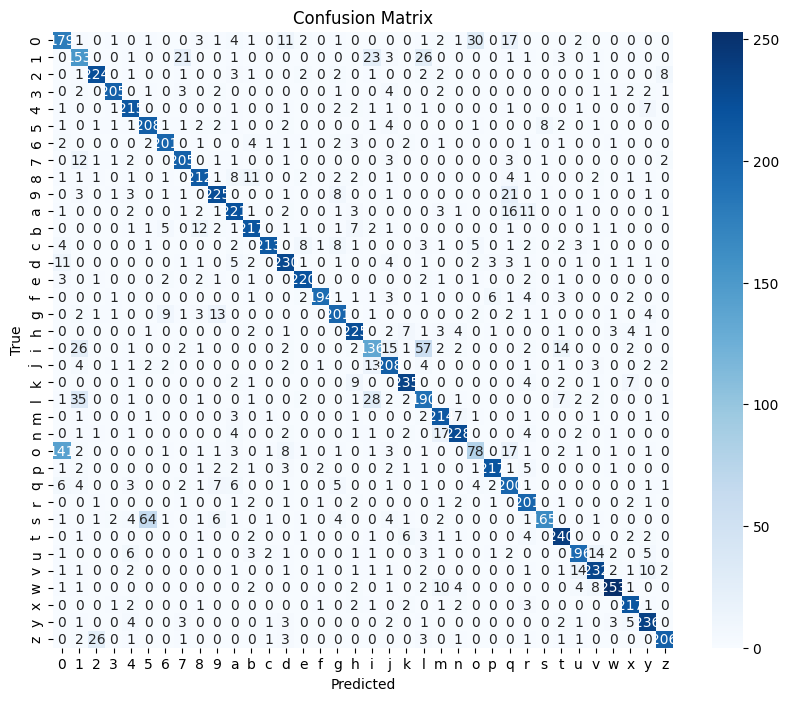

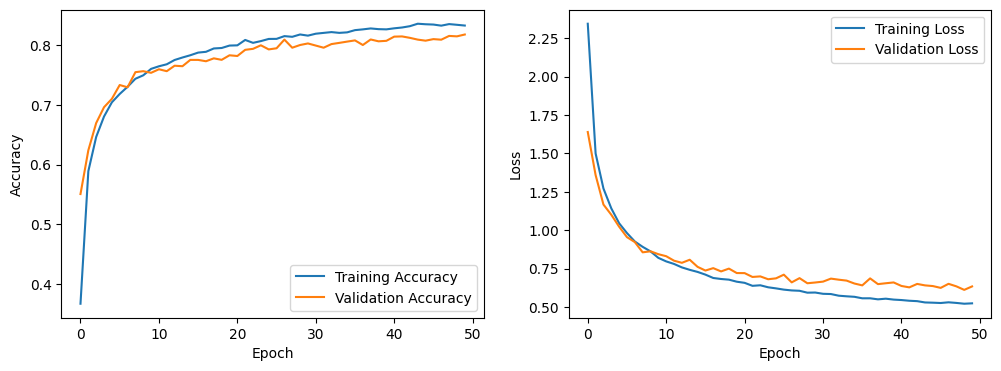

In [12]:
# TODO: Create new conda env for this. Default one having issue with keras

from tf_keras.models import Sequential
from tf_keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tf_keras.preprocessing.image import ImageDataGenerator
from tf_keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils import shuffle
import seaborn as sns

# Shuffle data before split so that the classes are not completely absent from either side
X_train, y_train = shuffle(X_train, y_train, random_state=42)

train_datagen = ImageDataGenerator(
    rotation_range=15,      # ±15 degree rotation
    width_shift_range=0.1,  # 10% horizontal shift
    height_shift_range=0.1, # 10% vertical shift
    zoom_range=0.1,         # 10% zoom
    shear_range=0.1,        # 10% shear
    validation_split=0.2,
)

# Use flow_from_dataframe if you have structured data
train_generator = train_datagen.flow(
    X_train, y_train,
    batch_size=32,
    subset="training"
)

val_generator = train_datagen.flow(
    X_train, y_train,
    batch_size=32,
    subset="validation"
)


def create_model(input_shape, num_classes):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        
        # Classifier
        Flatten(),
        Dense(128, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])
    
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model


num_classes = len(label_encoder.classes_)
input_shape = X_train.shape[1:]
model = create_model(input_shape=input_shape, num_classes=num_classes)
model.summary()

callbacks = [
    EarlyStopping(patience=5, restore_best_weights=True),
    ReduceLROnPlateau(factor=0.1, patience=3)
]

history = model.fit(train_generator,
                    epochs=50,
                    batch_size=32,
                    validation_data=val_generator)

# Evaluate on test set
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
print(f"\nTest accuracy: {test_acc:.4f}")
print(f"Test loss: {test_loss:.4f}")

# Generate predictions
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_classes, 
                           target_names=label_encoder.classes_))

# Confusion matrix
plt.figure(figsize=(10,8))
cm = confusion_matrix(y_test, y_pred_classes)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Save the model
model.save('character_recognition_model.keras')


Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_23 (Conv2D)          (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d_16 (MaxPooli  (None, 13, 13, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_24 (Conv2D)          (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_17 (MaxPooli  (None, 5, 5, 64)          0         
 ng2D)                                                           
                                                                 
 conv2d_25 (Conv2D)          (None, 3, 3, 128)         73856     
                                                                 
 flatten_8 (Flatten)         (None, 1152)             

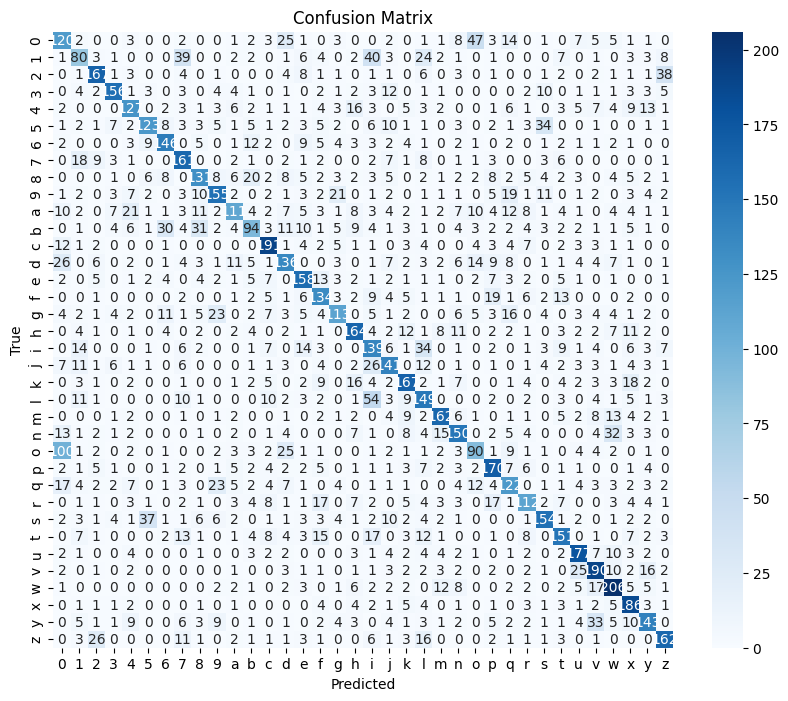

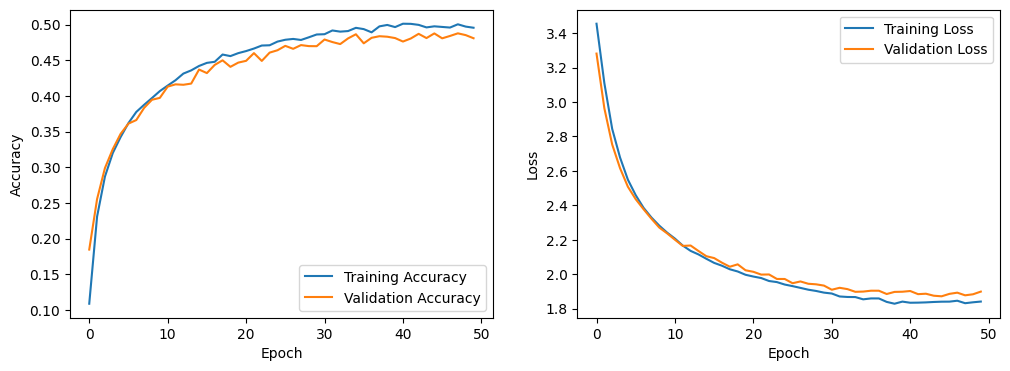

In [54]:
# TODO: Create new conda env for this. Default one having issue with keras
from tf_keras.models import Sequential
from tf_keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tf_keras.preprocessing.image import ImageDataGenerator
from tf_keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tf_keras.utils import to_categorical
from tf_keras.optimizers import Adam
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils import shuffle
import seaborn as sns

def create_model(input_shape, num_classes):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(128, (3, 3), activation='relu'),

        Flatten(),
        Dense(128, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer=Adam(learning_rate=1e-3),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model


num_classes = len(label_encoder.classes_)
input_shape = X_train.shape[1:]
model = create_model(input_shape=input_shape, num_classes=num_classes)
model.summary()

callbacks = [
    EarlyStopping(patience=5, restore_best_weights=True),
    ReduceLROnPlateau(factor=0.1, patience=3)
]



import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def load_emnist_from_csv(csv_path):
    """Load EMNIST data from CSV file"""
    df = pd.read_csv(csv_path, header=None)
    labels = df.iloc[:, 0].values
    images = df.iloc[:, 1:].values
    return images, labels

def preprocess_emnist(images, labels):
    """Preprocess EMNIST images and labels"""
    # Reshape to 28x28 and transpose (EMNIST images are rotated)
    images = images.reshape((-1, 28, 28)).transpose(0, 2, 1)
    
    # Flip images to correct orientation
    # images = np.array([np.fliplr(img) for img in images])
    
    # Normalize pixel values
    images = images.astype('float32') / 255.0
    
    # Add channel dimension (for CNN input)
    images = np.expand_dims(images, axis=-1)
    
    return images, labels

def create_label_mapping():
    # For merged case (36 classes: 0-9 + A-Z)
    label_names = [str(i) for i in range(10)]  # Digits 0-9
    label_names += [chr(65 + i) for i in range(26)]  # A-Z
    label_names += [chr(97 + i) for i in range(26)]  # a-z
    return label_names


# Create mapping (assuming you've merged cases as before)
label_mapping = create_label_mapping()  

# Example usage with your data
def convert_labels(y_numerical):
    """Convert numerical labels to character labels"""
    return [label_mapping[label] for label in y_numerical]

def merge_case_labels(y_original):
    """Convert labels so uppercase and lowercase of same letter have same class"""
    y_new = y_original.copy()
    
    # Digits 0-9 remain unchanged (labels 0-9)
    # Letters A-Z and a-z need to be merged
    
    # For uppercase letters (A-Z is 10-35 in original labels)
    upper_case = (y_original >= 10) & (y_original <= 35)
    # Convert to 10-35 (same as original)
    
    # For lowercase letters (a-z is 36-61 in original labels)
    lower_case = (y_original >= 36) & (y_original <= 61)
    # Convert to 10-35 (matching their uppercase counterparts)
    y_new[upper_case] = y_new[upper_case] + 26
    
    return y_new


# Load training data
train_images, train_labels = load_emnist_from_csv('emnist-byclass-train.csv')
train_images, train_labels = preprocess_emnist(train_images, train_labels)

# Load test data
test_images, test_labels = load_emnist_from_csv('emnist-byclass-test.csv')
test_images, test_labels = preprocess_emnist(test_images, test_labels)

# Apply to both train and test sets
train_labels = np.array(merge_case_labels(train_labels))
test_labels = np.array(merge_case_labels(test_labels))

#Convert labels
train_labels = np.array(convert_labels(train_labels))
test_labels = np.array(convert_labels(test_labels))

train_labels = label_encoder.transform(train_labels)
test_labels = label_encoder.transform(test_labels)

# Now we have 36 classes (0-9 digits + 26 letters)
num_classes = 36

# Create and train model (using num_classes=36 now)
model.fit(train_images, train_labels,
          epochs=20,
          batch_size=128,
          validation_data=(test_images, test_labels))



# Shuffle data before split so that the classes are not completely absent from either side
X_train, Y_train = shuffle(X_train, Y_train, random_state=42)

train_datagen = ImageDataGenerator(
    rotation_range=15,      # ±15 degree rotation
    width_shift_range=0.1,  # 10% horizontal shift
    height_shift_range=0.1, # 10% vertical shift
    zoom_range=0.1,         # 10% zoom
    shear_range=0.1,        # 10% shear
    validation_split=0.2,
)

# Use flow_from_dataframe if you have structured data
train_generator = train_datagen.flow(
    X_train, Y_train,
    batch_size=32,
    subset="training"
)

val_generator = train_datagen.flow(
    X_train, Y_train,
    batch_size=32,
    subset="validation"
)

# 1. Freeze Convolutional Base
for layer in model.layers[:-3]:  # Freeze all layers except last dense layers
    layer.trainable = False

# 2. Modify the Top Layers
# Remove original classification head (last 2 layers)
model.pop()  # Remove output layer
model.pop()  # Remove dense layer

# Add new dense layers for custom dataset
model.add(Dense(64, activation='relu', name='new_dense'))
model.add(Dense(num_classes, activation='softmax', name='new_output'))

# 3. Recompile with Lower Learning Rate
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# 4. Display Trainable Layers
for i, layer in enumerate(model.layers):
    print(f"Layer {i}: {layer.name} - Trainable: {layer.trainable}")

# 5. Fine-Tune on Custom Data
history = model.fit(
    train_generator,
    epochs=100,
    batch_size=32,
    validation_data=val_generator,
    callbacks=callbacks
)


# history = model.fit(train_generator,
#                     epochs=50,
#                     batch_size=32,
#                     validation_data=val_generator)

# Evaluate on test set
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
print(f"\nTest accuracy: {test_acc:.4f}")
print(f"Test loss: {test_loss:.4f}")

# Generate predictions
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_classes, 
                           target_names=label_encoder.classes_))

# Confusion matrix
plt.figure(figsize=(10,8))
cm = confusion_matrix(y_test, y_pred_classes)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Save the model
model.save('character_recognition_model.keras')


Training images shape: (697932, 28, 28, 1)
Training labels shape: (697932,)


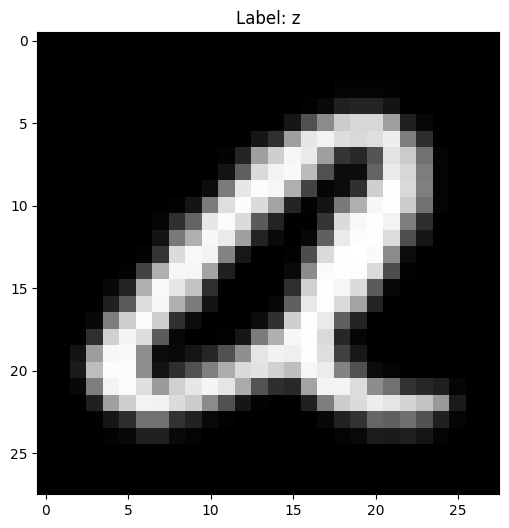

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def load_emnist_from_csv(csv_path):
    """Load EMNIST data from CSV file"""
    df = pd.read_csv(csv_path, header=None)
    labels = df.iloc[:, 0].values
    images = df.iloc[:, 1:].values
    return images, labels

def preprocess_emnist(images, labels):
    """Preprocess EMNIST images and labels"""
    # Reshape to 28x28 and transpose (EMNIST images are rotated)
    images = images.reshape((-1, 28, 28)).transpose(0, 2, 1)
    
    # Flip images to correct orientation
    # images = np.array([np.fliplr(img) for img in images])
    
    # Normalize pixel values
    images = images.astype('float32') / 255.0
    
    # Add channel dimension (for CNN input)
    images = np.expand_dims(images, axis=-1)
    
    return images, labels

def create_label_mapping():
    # For merged case (36 classes: 0-9 + A-Z)
    label_names = [str(i) for i in range(10)]  # Digits 0-9
    label_names += [chr(65 + i) for i in range(26)]  # A-Z
    label_names += [chr(97 + i) for i in range(26)]  # a-z
    return label_names


# Create mapping (assuming you've merged cases as before)
label_mapping = create_label_mapping()  

# Example usage with your data
def convert_labels(y_numerical):
    """Convert numerical labels to character labels"""
    return [label_mapping[label] for label in y_numerical]

def merge_case_labels(y_original):
    """Convert labels so uppercase and lowercase of same letter have same class"""
    y_new = y_original.copy()
    
    # Digits 0-9 remain unchanged (labels 0-9)
    # Letters A-Z and a-z need to be merged
    
    # For uppercase letters (A-Z is 10-35 in original labels)
    upper_case = (y_original >= 10) & (y_original <= 35)
    # Convert to 10-35 (same as original)
    
    # For lowercase letters (a-z is 36-61 in original labels)
    lower_case = (y_original >= 36) & (y_original <= 61)
    # Convert to 10-35 (matching their uppercase counterparts)
    y_new[upper_case] = y_new[upper_case] + 26
    
    return y_new


# Load training data
train_images, train_labels = load_emnist_from_csv('emnist-byclass-train.csv')
train_images, train_labels = preprocess_emnist(train_images, train_labels)

# Load test data
test_images, test_labels = load_emnist_from_csv('emnist-byclass-test.csv')
test_images, test_labels = preprocess_emnist(test_images, test_labels)

# Apply to both train and test sets
train_labels = np.array(merge_case_labels(train_labels))
test_labels = np.array(merge_case_labels(test_labels))

#Convert labels
train_labels = np.array(convert_labels(train_labels))
test_labels = np.array(convert_labels(test_labels))

# Verify data shape
print("Training images shape:", train_images.shape) 
print("Training labels shape:", train_labels.shape)

# Visualize sample image
plt.figure(figsize=(6, 6))
plt.imshow(train_images[0].squeeze(), cmap='gray')
plt.title(f"Label: {train_labels[0]}")
plt.show()

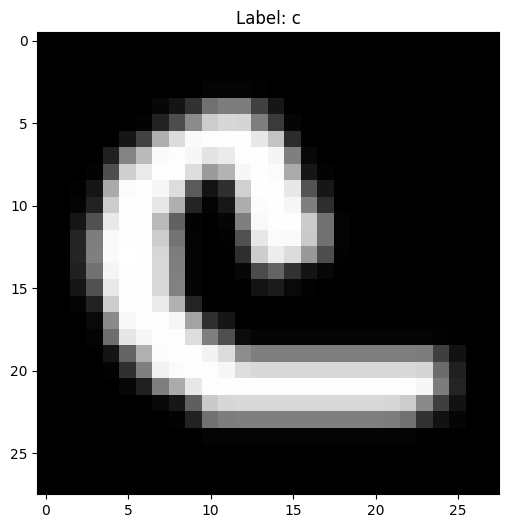

In [40]:
plt.figure(figsize=(6, 6))
plt.imshow(train_images[5].squeeze(), cmap='gray')
plt.title(f"Label: {train_labels[5]}")
plt.show()